In [1]:
MODEL = 'models/wino-1GeV-0'
INDIR_TEST = 'data/'
NO_OF_PARTICLES = 250
PT_CUT = 1.0

In [2]:
import numpy as np
import awkward0 as awkward
from dataset import *
from cosine_decay import *
import sys,os

In [3]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU') # disabling GPU, comment out if you want to use GPU

# uncomment and adjust for GPU calculations
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

# # dynamic memory growth
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from os.path import join, basename, dirname, exists
from tensorflow.keras.optimizers import *
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
# from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import *
from sklearn.metrics import accuracy_score
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import preprocessing

### Set up plot font

In [5]:
from matplotlib import rc
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
rc('legend',fontsize=10)
rc('axes', titlesize=16)
rc('axes', labelsize=12) 
rc('xtick', labelsize=10) 
rc('ytick', labelsize=10) 


In [6]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

In [7]:
def apply_pt_cut(data, cut=1.0):
    cond = data.X['mask'] < np.log(cut)
    cond2 = data.X['mask'] >= np.log(cut)
    print(cond.shape)
    print('below the cut: ', np.sum(cond))
    print('above the cut: ', np.sum(cond2))
    print('sum: ', np.sum(cond) + np.sum(cond2))
    data.X['mask'][cond] = 0.0
    ext_shape = list(cond.shape)
    ext_shape[-1] = 4
    new_cond = np.repeat(cond, 5, axis=2)
    print(new_cond.shape)
    data.X['features'][new_cond] = 0.0
  
    return data, np.sum(cond2, axis=1).flatten()

# SM and wino300 samples

In [8]:
def load_scaler(model, name='scaler.txt'):
    with open(join(model, name), 'r') as f:
        lines = f.readlines()
    dic = {}
    key = None
    for ii, ll in enumerate(lines):
#         print(f'ii={ii}', f'key={key}', f'll={ll}')
        if ii%4 == 0:
            if key is not None:
                dic[key] = entry
            key = ll.strip()
            entry = {}
        elif ':' in ll:
            tokens = ll.split(':')
            entry[tokens[0]] = float(tokens[-1])
        if ii == len(lines)-1:
            dic[key] = entry
    return dic

In [9]:
all_predictions = {}
all_sq_pt = {}
bkg_dat = Dataset(f'{INDIR_TEST}/sm_test.awkd', {}, data_format='channel_last', pad_len=NO_OF_PARTICLES)
sig_dat = Dataset(f'{INDIR_TEST}/wino_test.awkd', {}, data_format='channel_last', pad_len=NO_OF_PARTICLES)

[2024-11-18 17:00:47,259] INFO: Start loading file data//sm_test.awkd
[2024-11-18 17:00:47,279] INFO: Loading points
[2024-11-18 17:00:47,280] INFO: Loading ['part_etarel', 'part_phirel']


Keys in the datafile found:
['track_momentum', 'track_pt', 'track_phi', 'track_eta', 'track_charge', 'track_origin', 'photon_energy', 'photon_ET', 'photon_phi', 'photon_eta', 'photon_charge', 'photon_origin', 'hadron_energy', 'hadron_ET', 'hadron_phi', 'hadron_eta', 'hadron_charge', 'hadron_origin', 'event_pt', 'event_eta', 'event_phi', 'event_mass', 'label', 'train_val_test', 'n_parts', 'jet_PT', 'jet_Eta', 'jet_Phi', 'jet_Mass', 'jet_Flavor', 'con_jet1_phi_arr', 'con_jet2_phi_arr', 'con_jet3_phi_arr', 'con_jet1_eta_arr', 'con_jet2_eta_arr', 'con_jet3_eta_arr', 'con_jet1_pt_arr', 'con_jet2_pt_arr', 'con_jet3_pt_arr', 'con_jet1_type_arr', 'con_jet2_type_arr', 'con_jet3_type_arr', 'origin', 'part_pt_log', 'part_ptrel', 'part_logptrel', 'part_e_log', 'part_erel', 'part_logerel', 'squark_pt', 'part_raw_etarel', 'part_etarel', 'part_phirel', 'part_deltaR', 'event_MET', 'event_HT', 'event_MT2']
Loading ['part_etarel', 'part_phirel']


[2024-11-18 17:00:48,755] INFO: Loading ['part_etarel', 'part_phirel']


Loading ['part_etarel', 'part_phirel']


[2024-11-18 17:00:50,483] INFO: Loading features
[2024-11-18 17:00:50,502] INFO: Loading ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel', 'origin']


Loading ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel', 'origin']


[2024-11-18 17:00:52,021] INFO: Loading ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel', 'origin']


Loading ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel', 'origin']


[2024-11-18 17:00:53,583] INFO: Loading ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel', 'origin']


Loading ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel', 'origin']


[2024-11-18 17:00:55,314] INFO: Loading ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel', 'origin']


Loading ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel', 'origin']


[2024-11-18 17:00:59,426] INFO: Loading ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel', 'origin']


Loading ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel', 'origin']


[2024-11-18 17:01:05,959] INFO: Loading mask
[2024-11-18 17:01:06,008] INFO: Loading ['part_pt_log']


Loading ['part_pt_log']


[2024-11-18 17:01:08,141] INFO: Loading origin
[2024-11-18 17:01:08,152] INFO: Loading ['origin']


Loading ['origin']


[2024-11-18 17:01:11,963] INFO: Loading track
[2024-11-18 17:01:11,971] INFO: Loading ['track_pt', 'track_eta', 'track_phi']


Loading ['track_pt', 'track_eta', 'track_phi']


[2024-11-18 17:01:13,446] INFO: Loading ['track_pt', 'track_eta', 'track_phi']


Loading ['track_pt', 'track_eta', 'track_phi']


[2024-11-18 17:01:15,242] INFO: Loading ['track_pt', 'track_eta', 'track_phi']


Loading ['track_pt', 'track_eta', 'track_phi']


[2024-11-18 17:01:17,662] INFO: Loading photon
[2024-11-18 17:01:17,686] INFO: Loading ['photon_ET', 'photon_eta', 'photon_phi']


Loading ['photon_ET', 'photon_eta', 'photon_phi']


[2024-11-18 17:01:18,882] INFO: Loading ['photon_ET', 'photon_eta', 'photon_phi']


Loading ['photon_ET', 'photon_eta', 'photon_phi']


[2024-11-18 17:01:20,311] INFO: Loading ['photon_ET', 'photon_eta', 'photon_phi']


Loading ['photon_ET', 'photon_eta', 'photon_phi']


[2024-11-18 17:01:22,636] INFO: Loading hadron
[2024-11-18 17:01:23,218] INFO: Loading ['hadron_ET', 'hadron_eta', 'hadron_phi']


Loading ['hadron_ET', 'hadron_eta', 'hadron_phi']


[2024-11-18 17:01:24,224] INFO: Loading ['hadron_ET', 'hadron_eta', 'hadron_phi']


Loading ['hadron_ET', 'hadron_eta', 'hadron_phi']


[2024-11-18 17:01:25,207] INFO: Loading ['hadron_ET', 'hadron_eta', 'hadron_phi']


Loading ['hadron_ET', 'hadron_eta', 'hadron_phi']


[2024-11-18 17:01:26,604] INFO: Loading jet
[2024-11-18 17:01:26,636] INFO: Loading ['jet_PT', 'jet_Eta', 'jet_Phi', 'jet_Mass', 'jet_Flavor']


Loading ['jet_PT', 'jet_Eta', 'jet_Phi', 'jet_Mass', 'jet_Flavor']


[2024-11-18 17:01:27,252] INFO: Loading ['jet_PT', 'jet_Eta', 'jet_Phi', 'jet_Mass', 'jet_Flavor']


Loading ['jet_PT', 'jet_Eta', 'jet_Phi', 'jet_Mass', 'jet_Flavor']


[2024-11-18 17:01:27,875] INFO: Loading ['jet_PT', 'jet_Eta', 'jet_Phi', 'jet_Mass', 'jet_Flavor']


Loading ['jet_PT', 'jet_Eta', 'jet_Phi', 'jet_Mass', 'jet_Flavor']


[2024-11-18 17:01:28,490] INFO: Loading ['jet_PT', 'jet_Eta', 'jet_Phi', 'jet_Mass', 'jet_Flavor']


Loading ['jet_PT', 'jet_Eta', 'jet_Phi', 'jet_Mass', 'jet_Flavor']


[2024-11-18 17:01:29,123] INFO: Loading ['jet_PT', 'jet_Eta', 'jet_Phi', 'jet_Mass', 'jet_Flavor']


Loading ['jet_PT', 'jet_Eta', 'jet_Phi', 'jet_Mass', 'jet_Flavor']


[2024-11-18 17:01:29,755] INFO: Loading squark
[2024-11-18 17:01:29,757] INFO: Loading ['squark_pt']


Loading ['squark_pt']


[2024-11-18 17:01:30,356] INFO: Loading jet1_con
[2024-11-18 17:01:30,357] INFO: Loading ['con_jet1_phi_arr', 'con_jet1_eta_arr', 'con_jet1_pt_arr', 'con_jet1_type_arr']


Loading ['con_jet1_phi_arr', 'con_jet1_eta_arr', 'con_jet1_pt_arr', 'con_jet1_type_arr']


[2024-11-18 17:01:31,154] INFO: Loading ['con_jet1_phi_arr', 'con_jet1_eta_arr', 'con_jet1_pt_arr', 'con_jet1_type_arr']


Loading ['con_jet1_phi_arr', 'con_jet1_eta_arr', 'con_jet1_pt_arr', 'con_jet1_type_arr']


[2024-11-18 17:01:31,971] INFO: Loading ['con_jet1_phi_arr', 'con_jet1_eta_arr', 'con_jet1_pt_arr', 'con_jet1_type_arr']


Loading ['con_jet1_phi_arr', 'con_jet1_eta_arr', 'con_jet1_pt_arr', 'con_jet1_type_arr']


[2024-11-18 17:01:32,758] INFO: Loading ['con_jet1_phi_arr', 'con_jet1_eta_arr', 'con_jet1_pt_arr', 'con_jet1_type_arr']


Loading ['con_jet1_phi_arr', 'con_jet1_eta_arr', 'con_jet1_pt_arr', 'con_jet1_type_arr']


[2024-11-18 17:01:34,034] INFO: Loading jet2_con
[2024-11-18 17:01:34,047] INFO: Loading ['con_jet2_phi_arr', 'con_jet2_eta_arr', 'con_jet2_pt_arr', 'con_jet2_type_arr']


Loading ['con_jet2_phi_arr', 'con_jet2_eta_arr', 'con_jet2_pt_arr', 'con_jet2_type_arr']


[2024-11-18 17:01:34,785] INFO: Loading ['con_jet2_phi_arr', 'con_jet2_eta_arr', 'con_jet2_pt_arr', 'con_jet2_type_arr']


Loading ['con_jet2_phi_arr', 'con_jet2_eta_arr', 'con_jet2_pt_arr', 'con_jet2_type_arr']


[2024-11-18 17:01:35,552] INFO: Loading ['con_jet2_phi_arr', 'con_jet2_eta_arr', 'con_jet2_pt_arr', 'con_jet2_type_arr']


Loading ['con_jet2_phi_arr', 'con_jet2_eta_arr', 'con_jet2_pt_arr', 'con_jet2_type_arr']


[2024-11-18 17:01:36,379] INFO: Loading ['con_jet2_phi_arr', 'con_jet2_eta_arr', 'con_jet2_pt_arr', 'con_jet2_type_arr']


Loading ['con_jet2_phi_arr', 'con_jet2_eta_arr', 'con_jet2_pt_arr', 'con_jet2_type_arr']


[2024-11-18 17:01:37,720] INFO: Loading jet3_con
[2024-11-18 17:01:37,735] INFO: Loading ['con_jet3_phi_arr', 'con_jet3_eta_arr', 'con_jet3_pt_arr', 'con_jet3_type_arr']


Loading ['con_jet3_phi_arr', 'con_jet3_eta_arr', 'con_jet3_pt_arr', 'con_jet3_type_arr']


[2024-11-18 17:01:38,489] INFO: Loading ['con_jet3_phi_arr', 'con_jet3_eta_arr', 'con_jet3_pt_arr', 'con_jet3_type_arr']


Loading ['con_jet3_phi_arr', 'con_jet3_eta_arr', 'con_jet3_pt_arr', 'con_jet3_type_arr']


[2024-11-18 17:01:39,285] INFO: Loading ['con_jet3_phi_arr', 'con_jet3_eta_arr', 'con_jet3_pt_arr', 'con_jet3_type_arr']


Loading ['con_jet3_phi_arr', 'con_jet3_eta_arr', 'con_jet3_pt_arr', 'con_jet3_type_arr']


[2024-11-18 17:01:40,102] INFO: Loading ['con_jet3_phi_arr', 'con_jet3_eta_arr', 'con_jet3_pt_arr', 'con_jet3_type_arr']


Loading ['con_jet3_phi_arr', 'con_jet3_eta_arr', 'con_jet3_pt_arr', 'con_jet3_type_arr']


[2024-11-18 17:01:41,538] INFO: Finished loading file data//sm_test.awkd
[2024-11-18 17:01:45,055] INFO: Start loading file data//wino_test.awkd


Dataset created!


[2024-11-18 17:01:45,348] INFO: Loading points
[2024-11-18 17:01:45,348] INFO: Loading ['part_etarel', 'part_phirel']


Keys in the datafile found:
['track_momentum', 'track_pt', 'track_phi', 'track_eta', 'track_charge', 'track_origin', 'photon_energy', 'photon_ET', 'photon_phi', 'photon_eta', 'photon_charge', 'photon_origin', 'hadron_energy', 'hadron_ET', 'hadron_phi', 'hadron_eta', 'hadron_charge', 'hadron_origin', 'event_pt', 'event_eta', 'event_phi', 'event_mass', 'label', 'train_val_test', 'n_parts', 'jet_PT', 'jet_Eta', 'jet_Phi', 'jet_Mass', 'jet_Flavor', 'con_jet1_phi_arr', 'con_jet2_phi_arr', 'con_jet3_phi_arr', 'con_jet1_eta_arr', 'con_jet2_eta_arr', 'con_jet3_eta_arr', 'con_jet1_pt_arr', 'con_jet2_pt_arr', 'con_jet3_pt_arr', 'con_jet1_type_arr', 'con_jet2_type_arr', 'con_jet3_type_arr', 'origin', 'part_pt_log', 'part_ptrel', 'part_logptrel', 'part_e_log', 'part_erel', 'part_logerel', 'squark_pt', 'part_raw_etarel', 'part_etarel', 'part_phirel', 'part_deltaR', 'event_MET', 'event_HT', 'event_MT2']
Loading ['part_etarel', 'part_phirel']


[2024-11-18 17:01:45,966] INFO: Loading ['part_etarel', 'part_phirel']


Loading ['part_etarel', 'part_phirel']


[2024-11-18 17:01:46,749] INFO: Loading features
[2024-11-18 17:01:46,760] INFO: Loading ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel', 'origin']


Loading ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel', 'origin']


[2024-11-18 17:01:47,578] INFO: Loading ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel', 'origin']


Loading ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel', 'origin']


[2024-11-18 17:01:48,466] INFO: Loading ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel', 'origin']


Loading ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel', 'origin']


[2024-11-18 17:01:49,600] INFO: Loading ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel', 'origin']


Loading ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel', 'origin']


[2024-11-18 17:01:50,521] INFO: Loading ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel', 'origin']


Loading ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel', 'origin']


[2024-11-18 17:01:52,550] INFO: Loading mask
[2024-11-18 17:01:52,574] INFO: Loading ['part_pt_log']


Loading ['part_pt_log']


[2024-11-18 17:01:53,363] INFO: Loading origin
[2024-11-18 17:01:53,368] INFO: Loading ['origin']


Loading ['origin']


[2024-11-18 17:01:54,960] INFO: Loading track
[2024-11-18 17:01:54,965] INFO: Loading ['track_pt', 'track_eta', 'track_phi']


Loading ['track_pt', 'track_eta', 'track_phi']


[2024-11-18 17:01:55,734] INFO: Loading ['track_pt', 'track_eta', 'track_phi']


Loading ['track_pt', 'track_eta', 'track_phi']


[2024-11-18 17:01:56,246] INFO: Loading ['track_pt', 'track_eta', 'track_phi']


Loading ['track_pt', 'track_eta', 'track_phi']


[2024-11-18 17:01:56,941] INFO: Loading photon
[2024-11-18 17:01:56,956] INFO: Loading ['photon_ET', 'photon_eta', 'photon_phi']


Loading ['photon_ET', 'photon_eta', 'photon_phi']


[2024-11-18 17:01:57,450] INFO: Loading ['photon_ET', 'photon_eta', 'photon_phi']


Loading ['photon_ET', 'photon_eta', 'photon_phi']


[2024-11-18 17:01:57,934] INFO: Loading ['photon_ET', 'photon_eta', 'photon_phi']


Loading ['photon_ET', 'photon_eta', 'photon_phi']


[2024-11-18 17:01:58,637] INFO: Loading hadron
[2024-11-18 17:01:58,655] INFO: Loading ['hadron_ET', 'hadron_eta', 'hadron_phi']


Loading ['hadron_ET', 'hadron_eta', 'hadron_phi']


[2024-11-18 17:01:59,380] INFO: Loading ['hadron_ET', 'hadron_eta', 'hadron_phi']


Loading ['hadron_ET', 'hadron_eta', 'hadron_phi']


[2024-11-18 17:01:59,979] INFO: Loading ['hadron_ET', 'hadron_eta', 'hadron_phi']


Loading ['hadron_ET', 'hadron_eta', 'hadron_phi']


[2024-11-18 17:02:00,914] INFO: Loading jet
[2024-11-18 17:02:00,928] INFO: Loading ['jet_PT', 'jet_Eta', 'jet_Phi', 'jet_Mass', 'jet_Flavor']


Loading ['jet_PT', 'jet_Eta', 'jet_Phi', 'jet_Mass', 'jet_Flavor']


[2024-11-18 17:02:01,231] INFO: Loading ['jet_PT', 'jet_Eta', 'jet_Phi', 'jet_Mass', 'jet_Flavor']


Loading ['jet_PT', 'jet_Eta', 'jet_Phi', 'jet_Mass', 'jet_Flavor']


[2024-11-18 17:02:01,533] INFO: Loading ['jet_PT', 'jet_Eta', 'jet_Phi', 'jet_Mass', 'jet_Flavor']


Loading ['jet_PT', 'jet_Eta', 'jet_Phi', 'jet_Mass', 'jet_Flavor']


[2024-11-18 17:02:01,833] INFO: Loading ['jet_PT', 'jet_Eta', 'jet_Phi', 'jet_Mass', 'jet_Flavor']


Loading ['jet_PT', 'jet_Eta', 'jet_Phi', 'jet_Mass', 'jet_Flavor']


[2024-11-18 17:02:02,128] INFO: Loading ['jet_PT', 'jet_Eta', 'jet_Phi', 'jet_Mass', 'jet_Flavor']


Loading ['jet_PT', 'jet_Eta', 'jet_Phi', 'jet_Mass', 'jet_Flavor']


[2024-11-18 17:02:02,439] INFO: Loading squark
[2024-11-18 17:02:02,439] INFO: Loading ['squark_pt']


Loading ['squark_pt']


[2024-11-18 17:02:02,733] INFO: Loading jet1_con
[2024-11-18 17:02:02,734] INFO: Loading ['con_jet1_phi_arr', 'con_jet1_eta_arr', 'con_jet1_pt_arr', 'con_jet1_type_arr']


Loading ['con_jet1_phi_arr', 'con_jet1_eta_arr', 'con_jet1_pt_arr', 'con_jet1_type_arr']


[2024-11-18 17:02:03,285] INFO: Loading ['con_jet1_phi_arr', 'con_jet1_eta_arr', 'con_jet1_pt_arr', 'con_jet1_type_arr']


Loading ['con_jet1_phi_arr', 'con_jet1_eta_arr', 'con_jet1_pt_arr', 'con_jet1_type_arr']


[2024-11-18 17:02:03,849] INFO: Loading ['con_jet1_phi_arr', 'con_jet1_eta_arr', 'con_jet1_pt_arr', 'con_jet1_type_arr']


Loading ['con_jet1_phi_arr', 'con_jet1_eta_arr', 'con_jet1_pt_arr', 'con_jet1_type_arr']


[2024-11-18 17:02:04,288] INFO: Loading ['con_jet1_phi_arr', 'con_jet1_eta_arr', 'con_jet1_pt_arr', 'con_jet1_type_arr']


Loading ['con_jet1_phi_arr', 'con_jet1_eta_arr', 'con_jet1_pt_arr', 'con_jet1_type_arr']


[2024-11-18 17:02:04,975] INFO: Loading jet2_con
[2024-11-18 17:02:04,982] INFO: Loading ['con_jet2_phi_arr', 'con_jet2_eta_arr', 'con_jet2_pt_arr', 'con_jet2_type_arr']


Loading ['con_jet2_phi_arr', 'con_jet2_eta_arr', 'con_jet2_pt_arr', 'con_jet2_type_arr']


[2024-11-18 17:02:05,351] INFO: Loading ['con_jet2_phi_arr', 'con_jet2_eta_arr', 'con_jet2_pt_arr', 'con_jet2_type_arr']


Loading ['con_jet2_phi_arr', 'con_jet2_eta_arr', 'con_jet2_pt_arr', 'con_jet2_type_arr']


[2024-11-18 17:02:05,770] INFO: Loading ['con_jet2_phi_arr', 'con_jet2_eta_arr', 'con_jet2_pt_arr', 'con_jet2_type_arr']


Loading ['con_jet2_phi_arr', 'con_jet2_eta_arr', 'con_jet2_pt_arr', 'con_jet2_type_arr']


[2024-11-18 17:02:06,223] INFO: Loading ['con_jet2_phi_arr', 'con_jet2_eta_arr', 'con_jet2_pt_arr', 'con_jet2_type_arr']


Loading ['con_jet2_phi_arr', 'con_jet2_eta_arr', 'con_jet2_pt_arr', 'con_jet2_type_arr']


[2024-11-18 17:02:06,914] INFO: Loading jet3_con
[2024-11-18 17:02:06,921] INFO: Loading ['con_jet3_phi_arr', 'con_jet3_eta_arr', 'con_jet3_pt_arr', 'con_jet3_type_arr']


Loading ['con_jet3_phi_arr', 'con_jet3_eta_arr', 'con_jet3_pt_arr', 'con_jet3_type_arr']


[2024-11-18 17:02:07,265] INFO: Loading ['con_jet3_phi_arr', 'con_jet3_eta_arr', 'con_jet3_pt_arr', 'con_jet3_type_arr']


Loading ['con_jet3_phi_arr', 'con_jet3_eta_arr', 'con_jet3_pt_arr', 'con_jet3_type_arr']


[2024-11-18 17:02:07,605] INFO: Loading ['con_jet3_phi_arr', 'con_jet3_eta_arr', 'con_jet3_pt_arr', 'con_jet3_type_arr']


Loading ['con_jet3_phi_arr', 'con_jet3_eta_arr', 'con_jet3_pt_arr', 'con_jet3_type_arr']


[2024-11-18 17:02:07,951] INFO: Loading ['con_jet3_phi_arr', 'con_jet3_eta_arr', 'con_jet3_pt_arr', 'con_jet3_type_arr']


Loading ['con_jet3_phi_arr', 'con_jet3_eta_arr', 'con_jet3_pt_arr', 'con_jet3_type_arr']


[2024-11-18 17:02:08,486] INFO: Finished loading file data//wino_test.awkd


Dataset created!


In [10]:
model_path = MODEL
model = load_model(model_path, custom_objects={'WarmUpCosineDecay': WarmUpCosineDecay})
dic = load_scaler(model_path, name='scaler.txt')
print('\n'.join(dic.keys()))
bkg = copy.deepcopy(bkg_dat)
sig = copy.deepcopy(sig_dat)
bkg.scale_data(dic)
sig.scale_data(dic)
bkg, npart_bkg  = apply_pt_cut(bkg, PT_CUT)
sig, npart_sig  = apply_pt_cut(sig, PT_CUT)
npart = [npart_bkg, npart_sig]
data = [bkg, sig]
Nmax = np.min([val.X['mask'].shape[0] for val in data])
print('---NMAX---', Nmax)
predictions = []
for ii, dset in enumerate(data):
    print(f'\tanalysing dataset {ii}')
    curr_dataset = dset
    dnn_vars = [curr_dataset['event_met'], curr_dataset['event_ht'], curr_dataset['event_eta'], curr_dataset['event_m'], curr_dataset['event_MT2'], ]
    for ii in range(0, 4):
        dnn_vars.append(curr_dataset.X['jet'][:, ii, 0])
        dnn_vars.append(curr_dataset.X['jet'][:, ii, 1])
        dnn_vars.append(curr_dataset.X['jet'][:, ii, 3])
        dnn_vars.append(curr_dataset['Dphi'][:, ii])
    input_vars = list(zip(*dnn_vars))
    model2_X = np.array(input_vars)[:Nmax]
    predictions.append(model.predict([model2_X, dset.X['points'][:Nmax], dset.X['features'][:Nmax], dset.X['mask'][:Nmax]]))
ypred = [item for sublist in predictions for item in sublist]
ypred2  = [t[0] for t in ypred]
all_predictions = ypred2
all_sq_pt = sig.X['squark'][:Nmax]

scaler_phi
scaler_eta
scaler_met
scaler_MT2
scaler_ht
scaler_m
scaler_jet1PT
scaler_jet1ETA
scaler_jet1MASS
scaler_jet1DPHI
scaler_jet2PT
scaler_jet2ETA
scaler_jet2MASS
scaler_jet2DPHI
scaler_jet3PT
scaler_jet3ETA
scaler_jet3MASS
scaler_jet3DPHI
scaler_jet4PT
scaler_jet4ETA
scaler_jet4MASS
scaler_jet4DPHI


[2024-11-18 17:02:34,237] INFO: Rescaling ev_phi
[2024-11-18 17:02:34,251] INFO: Rescaling ev_eta
[2024-11-18 17:02:34,255] INFO: Rescaling ev_met
[2024-11-18 17:02:34,258] INFO: Rescaling ev_MT2
[2024-11-18 17:02:34,261] INFO: Rescaling ev_ht
[2024-11-18 17:02:34,269] INFO: Rescaling ev_m
[2024-11-18 17:02:34,272] INFO: Rescaling jet1
[2024-11-18 17:02:34,312] INFO: Rescaling jet2
[2024-11-18 17:02:34,324] INFO: Rescaling jet3
[2024-11-18 17:02:34,334] INFO: Rescaling jet4
[2024-11-18 17:02:34,344] INFO: Rescaling ev_phi
[2024-11-18 17:02:34,345] INFO: Rescaling ev_eta
[2024-11-18 17:02:34,346] INFO: Rescaling ev_met
[2024-11-18 17:02:34,347] INFO: Rescaling ev_MT2
[2024-11-18 17:02:34,348] INFO: Rescaling ev_ht
[2024-11-18 17:02:34,349] INFO: Rescaling ev_m
[2024-11-18 17:02:34,351] INFO: Rescaling jet1
[2024-11-18 17:02:34,368] INFO: Rescaling jet2
[2024-11-18 17:02:34,372] INFO: Rescaling jet3
[2024-11-18 17:02:34,376] INFO: Rescaling jet4


(723474, 250, 1)
below the cut:  40532174
above the cut:  140336326
sum:  180868500
(723474, 250, 5)
(350277, 250, 1)
below the cut:  19139044
above the cut:  68430206
sum:  87569250
(350277, 250, 5)
---NMAX--- 350277
	analysing dataset 0


2024-11-18 17:02:49.259104: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


	analysing dataset 1


In [11]:
ytrue = []
for di, dset in enumerate(data):
    ytrue.append([di]*Nmax)
ytrue = [item for sublist in ytrue for item in sublist]

In [12]:
assert len(ytrue) == len(ypred)

In [13]:
y_true = np.array(ytrue)
y_pred = np.array(all_predictions)

# Score histogram

350277 (350277,) [60785.375 60785.254 60785.09  ... 60785.203 60785.27  60785.266]


<Figure size 640x480 with 0 Axes>

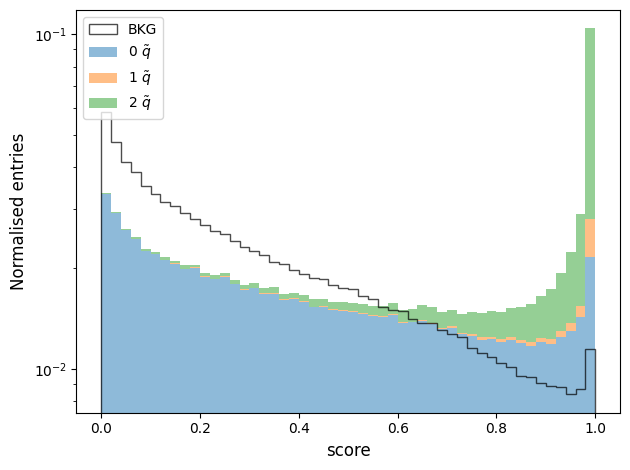

In [14]:
plt.clf()
fig = plt.figure()
w_bkg = np.ones(Nmax)/Nmax
plt.hist(y_pred[y_true==0], 50, weights=w_bkg, histtype='step', color='k', label='BKG', alpha=0.7)

Y_sig = y_pred[y_true==1]
# no squarks
zero_sq = np.ndarray.flatten(sig.X['squark'][:Nmax][:,0] == 0)
w_zero = np.ones(np.sum(zero_sq))/Nmax
# one squark
cond = (sig.X['squark'][:Nmax][:,0] > 0) * (sig.X['squark'][:Nmax][:,1] == 0)
one_sq = np.ndarray.flatten(cond)
w_one = np.ones(np.sum(one_sq))/Nmax
# two squarks
two_sq = np.ndarray.flatten(sig.X['squark'][:Nmax][:,1] > 0)
w_two = np.ones(np.sum(two_sq))/Nmax

print(Nmax, y_pred[y_true==0].shape, (Y_sig[zero_sq]) + len(Y_sig[one_sq])+ len(Y_sig[two_sq]))

plt.hist( [Y_sig[zero_sq],Y_sig[one_sq], Y_sig[two_sq]],
         50,
         weights = [w_zero, w_one, w_two],
         histtype='barstacked', stacked=True, alpha=0.5, 
         label=[r'0 $\tilde q$',r'1 $\tilde q$',r'2 $\tilde q$'] )
plt.legend()
plt.yscale('log')
plt.xlabel('score')
plt.ylabel('Normalised entries')
plt.tight_layout()
plt.show()